In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import math

In [ ]:
import zipfile

zip_path = "/content/network_intrusion_dataset(CIC-IDS-2017).zip"
extract_path = "/content/Network Intrusion dataset(CIC-IDS- 2017)"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
folder = "Network Intrusion dataset(CIC-IDS- 2017)"

# features used for UI input + label
selected_features = [
    'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
    'Fwd Packet Length Mean', 'Bwd Packet Length Mean',
    'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
    'Fwd IAT Mean', 'Bwd IAT Mean',
    'Fwd Header Length', 'Bwd Header Length',
    'Packet Length Mean', 'Packet Length Std',
    'ACK Flag Count', 'URG Flag Count',
    'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
    'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
    'Label'
]

selected_features_lower = [f.strip() for f in selected_features]

all_data = []

for file in os.listdir(folder):
    if file.endswith('.csv'):
        print(f"\nProcessing: {file}")
        path = os.path.join(folder, file)
        try:
            df = pd.read_csv(path, low_memory=False)

            df.columns = [col.strip() for col in df.columns]

            # Detect label column
            label_col = None
            for col in df.columns:
                if 'label' in col.lower() or 'attack' in col.lower():
                    label_col = col
                    break

            if not label_col:
                print(f"Skipped {file}: No label column found.")
                continue

            df_columns_stripped = [col.strip() for col in df.columns]
            if all(feature in df_columns_stripped for feature in selected_features_lower):

                col_mapping = {
                    f: df.columns[df_columns_stripped.index(f)] for f in selected_features_lower
                }

                needed_columns = list(col_mapping.values()) + [label_col]

                df = df[needed_columns]
                df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
                df.dropna(inplace=True)

                rename_map = {v: k for k, v in col_mapping.items()}
                df.rename(columns=rename_map, inplace=True)
                df.rename(columns={label_col: 'Label'}, inplace=True)

                all_data.append(df)
            else:
                print(f"Skipped {file}: Required features not found.")

        except Exception as e:
            print(f"Error processing {file}: {e}")

# Combine all cleaned DataFrames
if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df.to_csv("cleaned_combined_dataset.csv", index=False)
    print("\nCombined cleaned dataset saved as 'cleaned_combined_dataset.csv'")
else:
    print("No valid data to combine.")



Processing: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv

Processing: Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv

Processing: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv

Processing: Monday-WorkingHours.pcap_ISCX.csv

Processing: Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv

Processing: Friday-WorkingHours-Morning.pcap_ISCX.csv

Processing: Tuesday-WorkingHours.pcap_ISCX.csv

Processing: Wednesday-workingHours.pcap_ISCX.csv

Combined cleaned dataset saved as 'cleaned_combined_dataset.csv'


In [ ]:
df = pd.read_csv("cleaned_combined_dataset.csv")

print("Attack Type Distribution:\n")
print(df['Label'].value_counts())


Attack Type Distribution:

Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


**Count Plot**

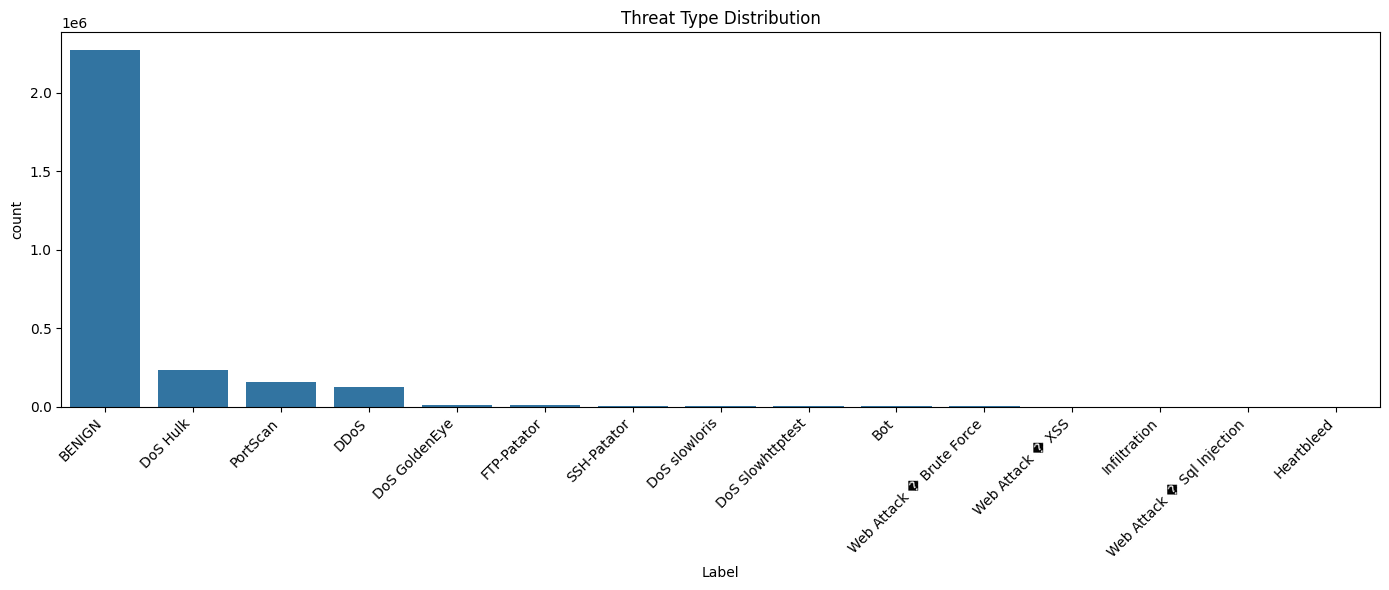

In [ ]:
plt.figure(figsize=(14,6))
sns.countplot(data=df, x='Label', order=df['Label'].value_counts().index)
plt.title("Threat Type Distribution")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.savefig("label_distribution_cleaned.png")
plt.show()

**Correlation Heatmap**


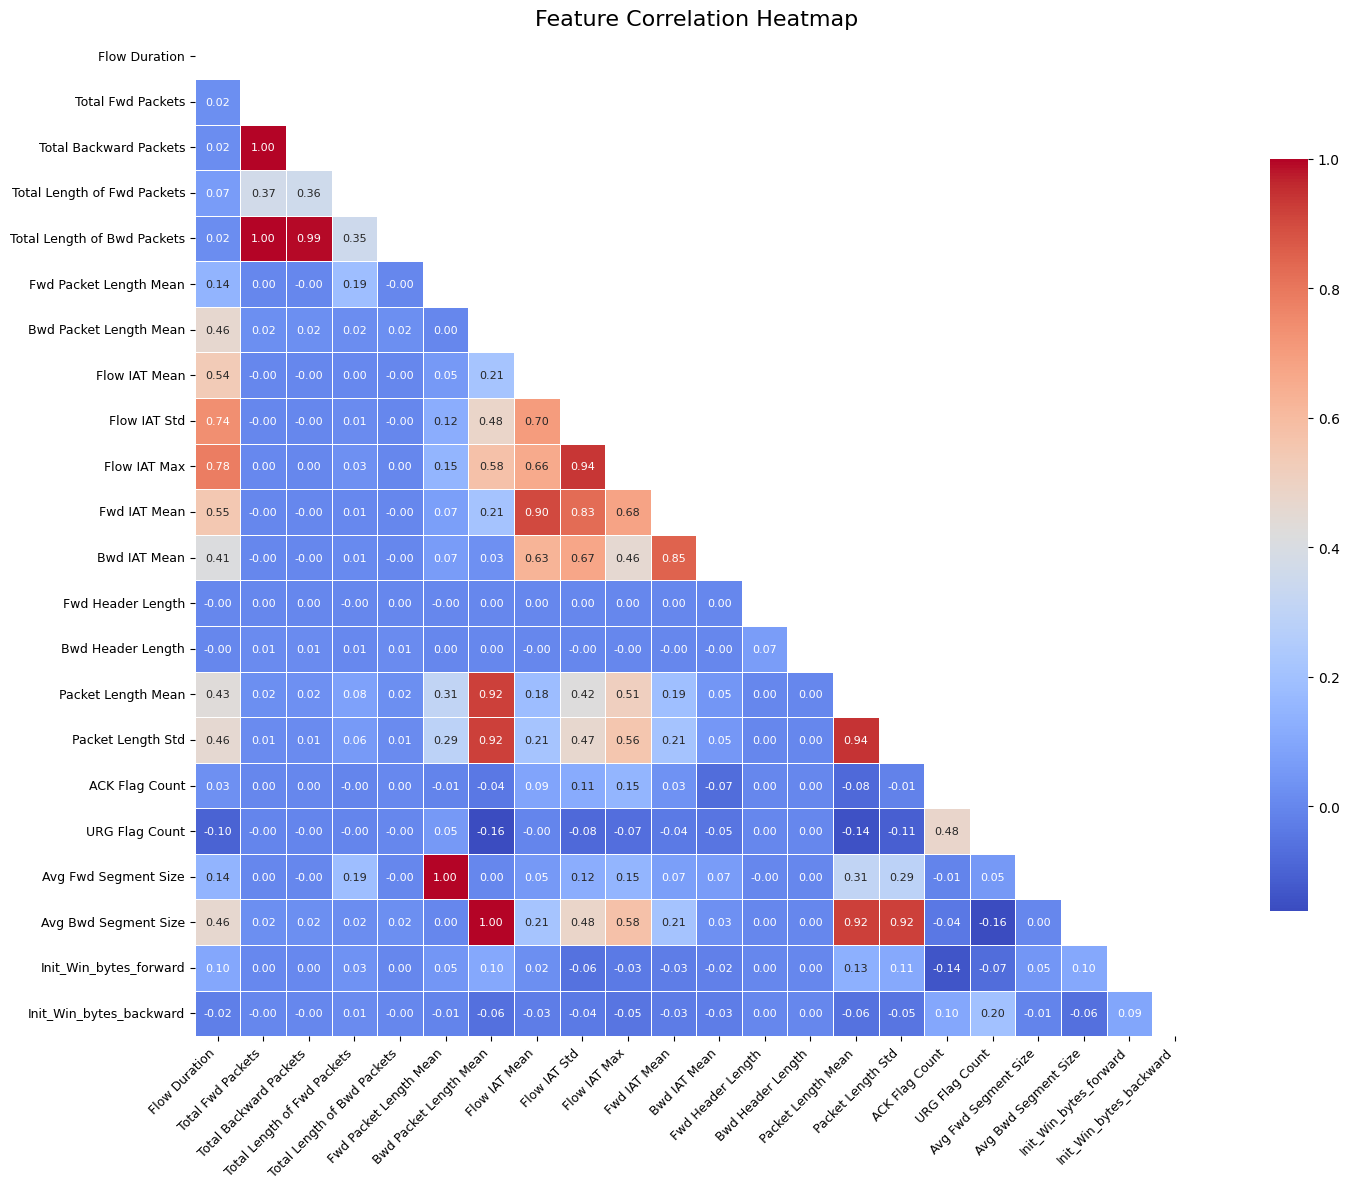

In [ ]:
plt.figure(figsize=(16, 12))

corr = df.drop(columns=['Label']).corr(numeric_only=True)

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", square=True,
            cbar_kws={"shrink": 0.75}, linewidths=0.5, annot_kws={"size": 8})

plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.savefig("correlation_heatmap_cleaned.png", dpi=300)
plt.show()



**Boxplot**

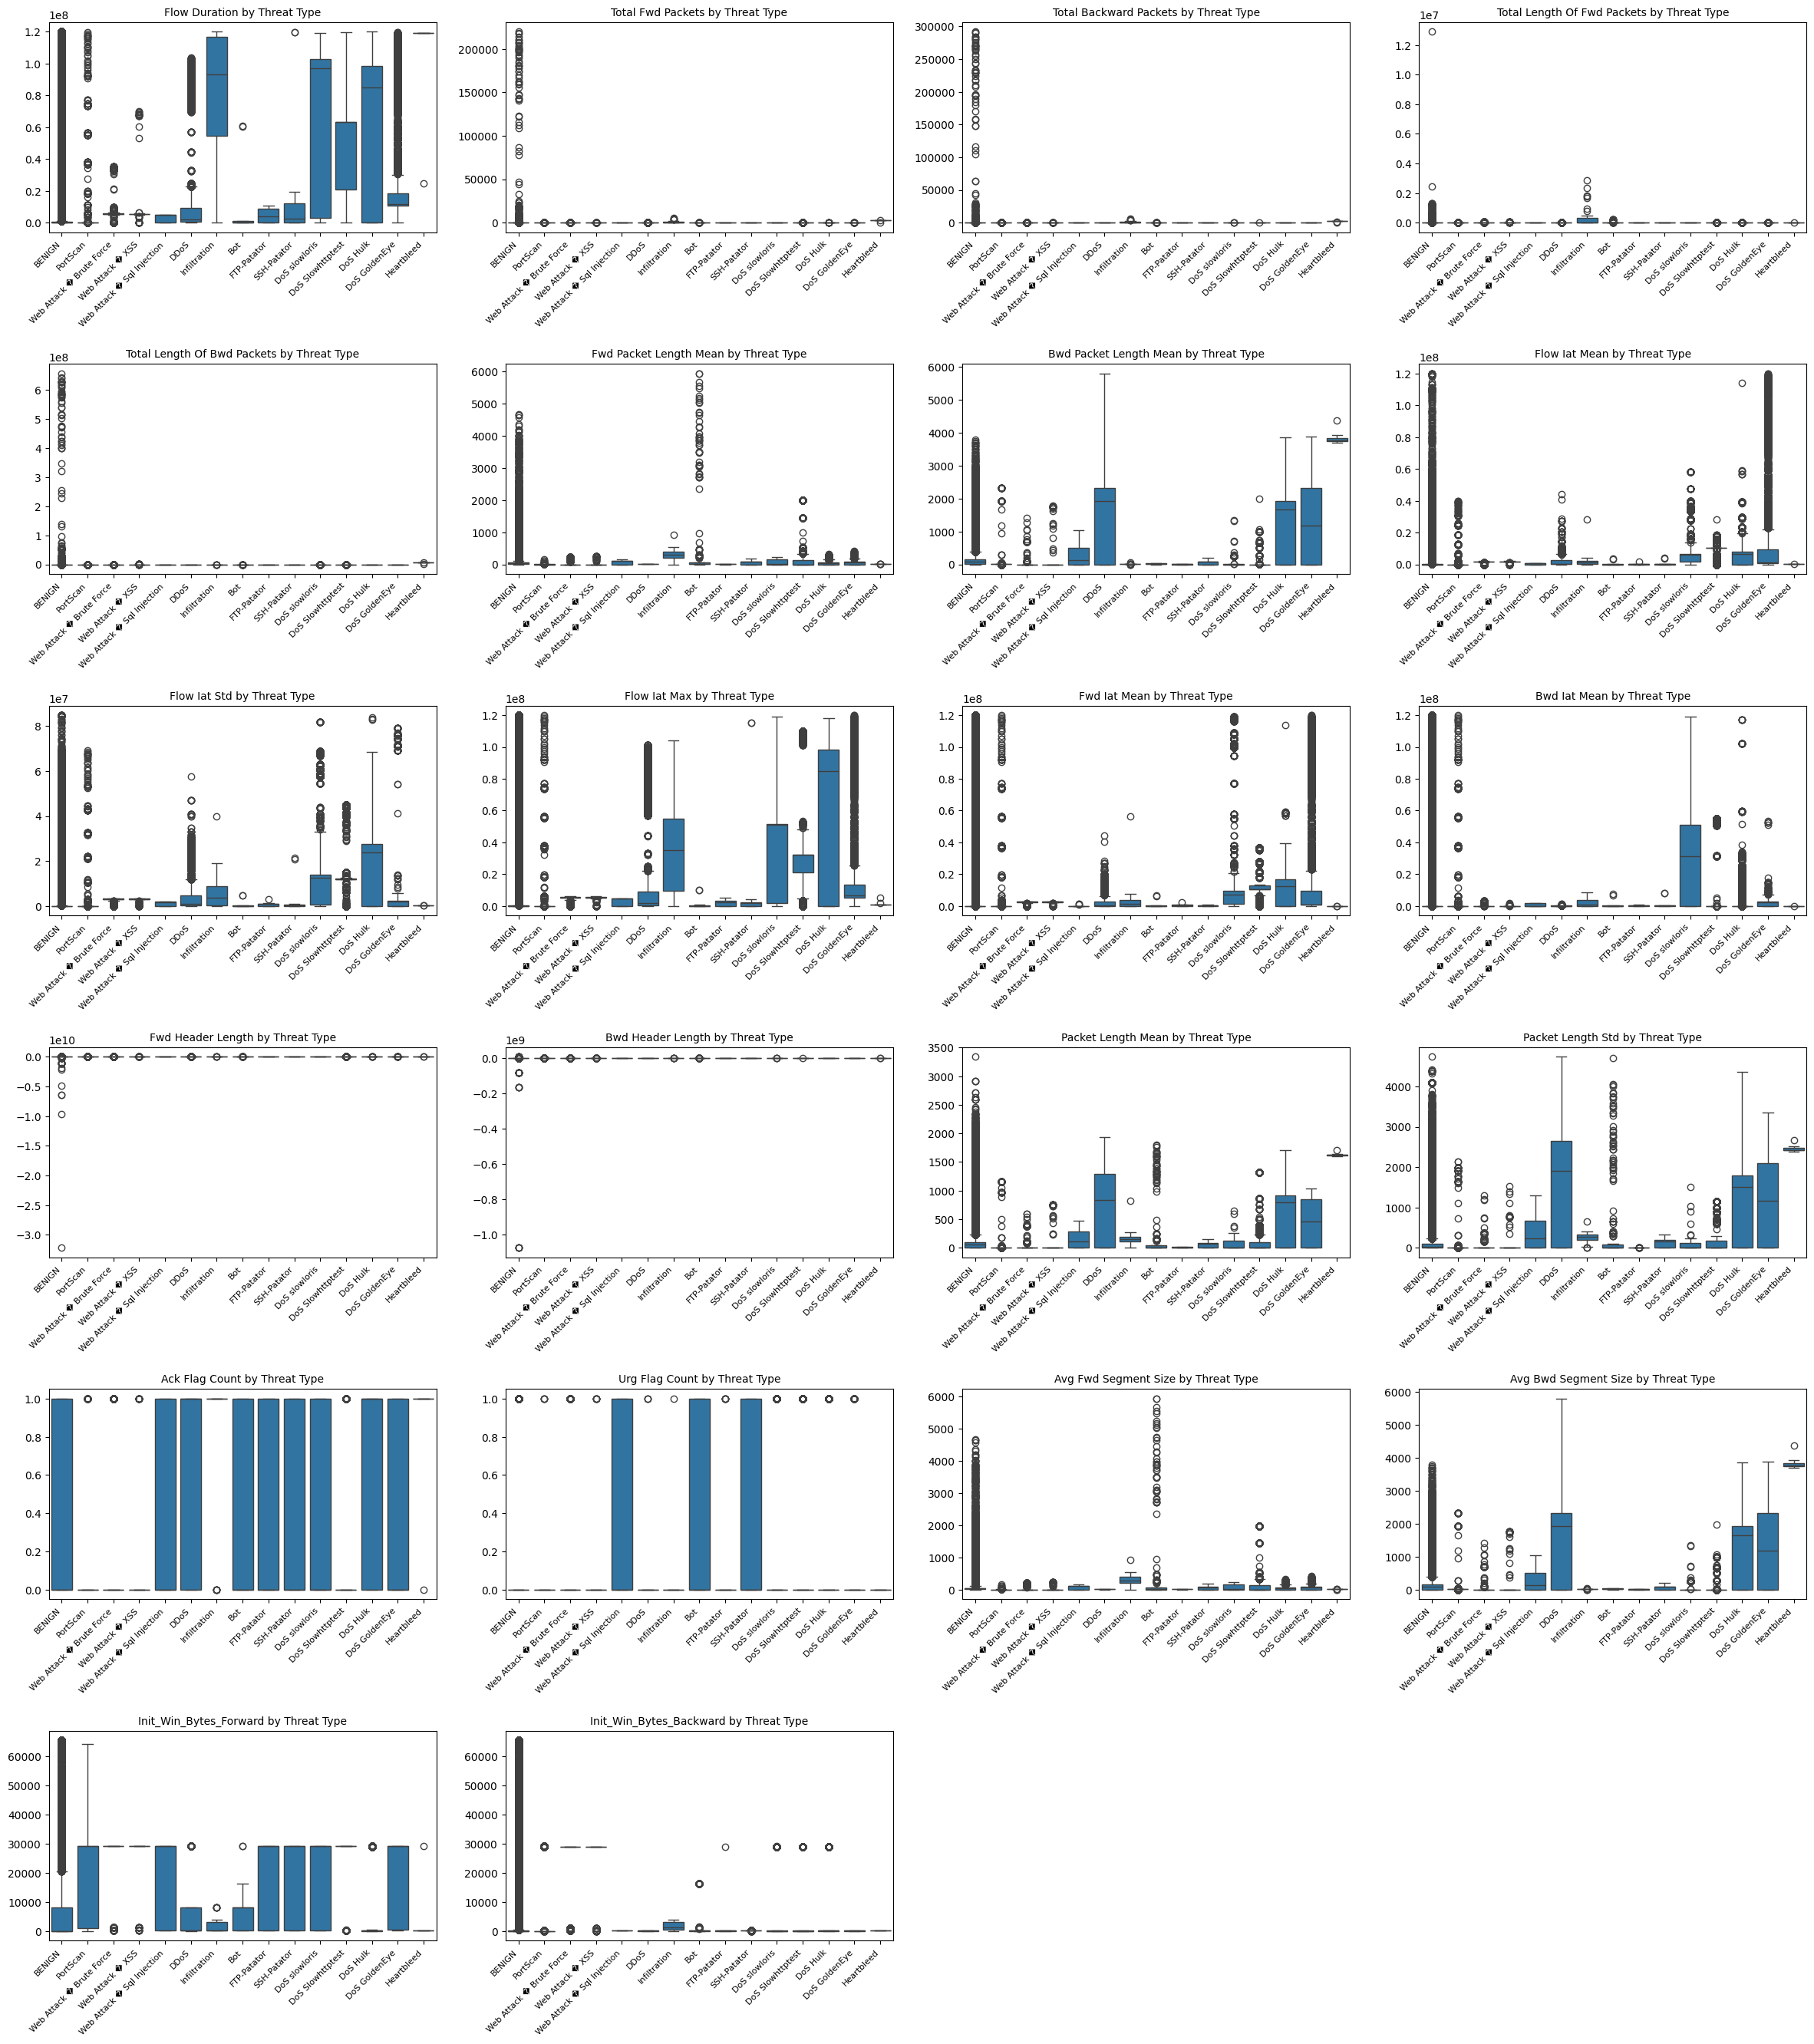

In [ ]:
features_to_plot = [
    'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
    'Fwd Packet Length Mean', 'Bwd Packet Length Mean',
    'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
    'Fwd IAT Mean', 'Bwd IAT Mean',
    'Fwd Header Length', 'Bwd Header Length',
    'Packet Length Mean', 'Packet Length Std',
    'ACK Flag Count', 'URG Flag Count',
    'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
    'Init_Win_bytes_forward', 'Init_Win_bytes_backward'
]

n = len(features_to_plot) #Total no. of plots

cols = 4
rows = math.ceil(n / cols)

plt.figure(figsize=(6 * cols, 4.5 * rows))

for idx, feature in enumerate(features_to_plot, 1):
    plt.subplot(rows, cols, idx)
    sns.boxplot(x='Label', y=feature, data=df)
    plt.title(f"{feature.title()} by Threat Type", fontsize=10)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout(pad=2.0)
plt.savefig("all_boxplots_by_threat_type.png", dpi=300)
plt.show()


**Histogram**

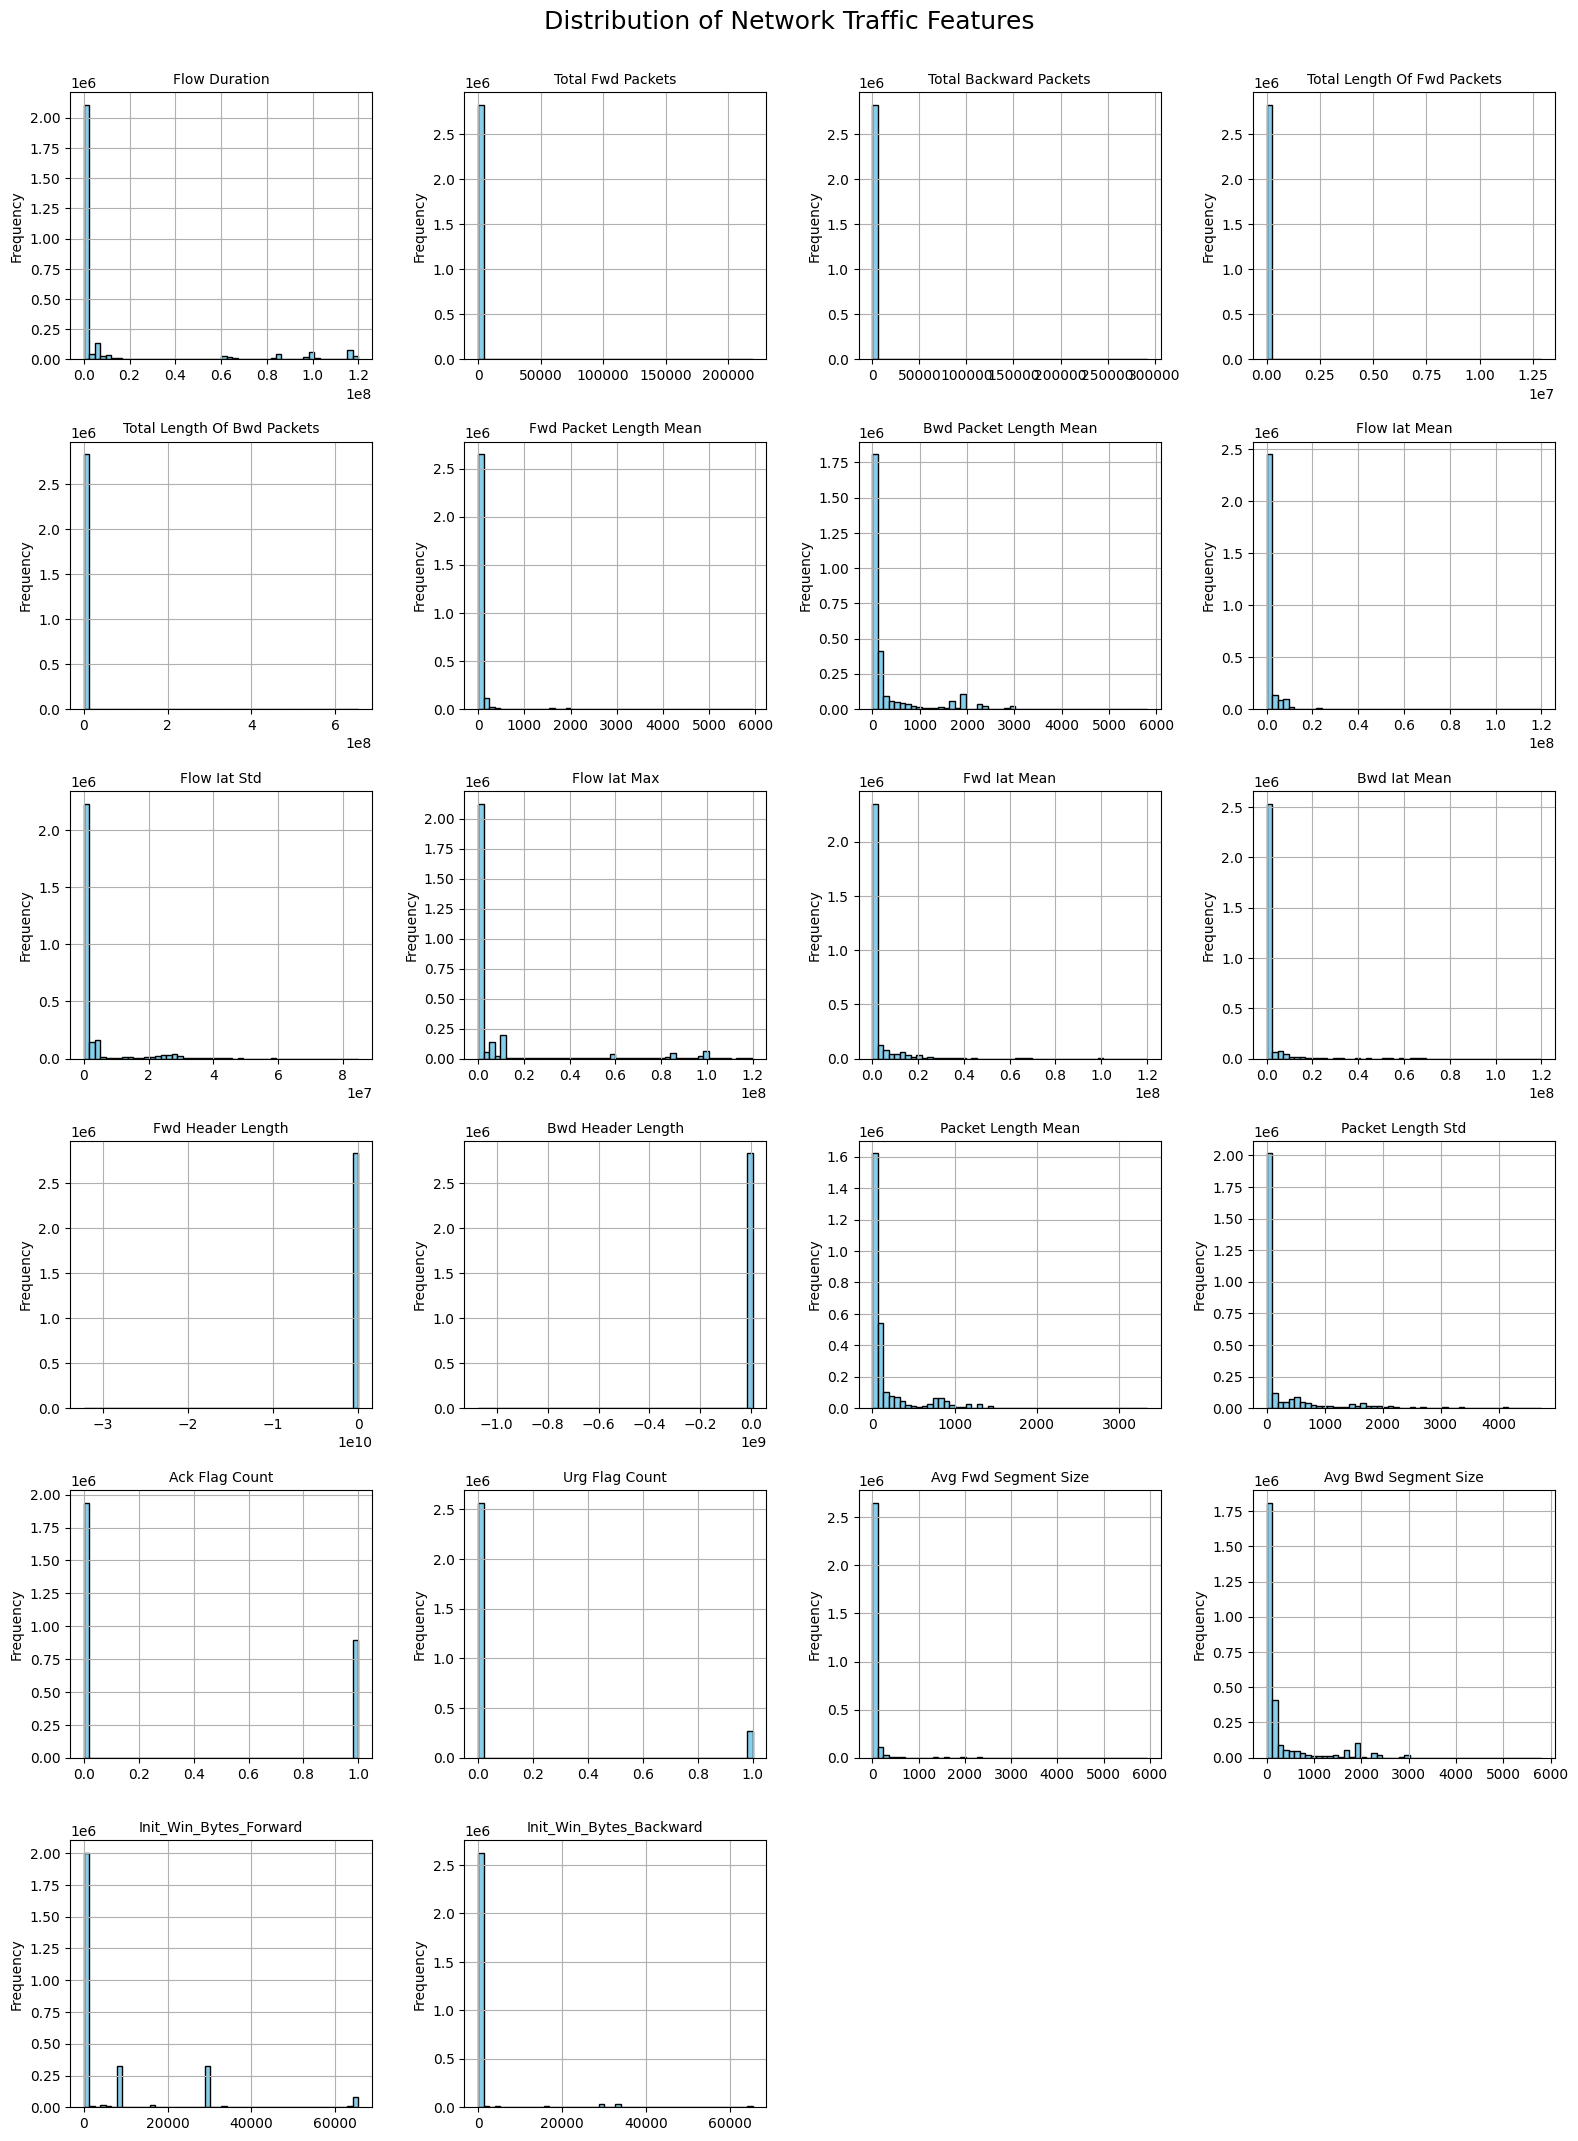

In [ ]:
n_features = len(features_to_plot)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(4 * n_cols, 3.5 * n_rows))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(n_rows, n_cols, i)
    df[feature].hist(bins=50, color='skyblue', edgecolor='black')
    plt.title(feature.title(), fontsize=10)
    plt.xlabel("")
    plt.ylabel("Frequency")
    plt.tight_layout(pad=1.5)

plt.suptitle("Distribution of Network Traffic Features", fontsize=18, y=1.02)
plt.savefig("histogram_grid_all_features.png", bbox_inches='tight', dpi=300)
plt.show()


**Balancing the Dataset**

In [ ]:
df = pd.read_csv("cleaned_combined_dataset.csv")

# Drop extra label columns
df = df.drop(columns=[col for col in df.columns if 'Label' in col and col != 'Label'], errors='ignore')
df = df.loc[:, ~df.columns.duplicated()]

# Remove rare classes (including encoding issues)
rare_classes = [
    'Heartbleed',
    'Web Attack – Sql Injection',
    'Web Attack � Sql Injection',
    'Infiltration'
]
df = df[~df['Label'].isin(rare_classes)]

# Sample only 10,000 BENIGN to prevent domination
df_benign = df[df['Label'] == 'BENIGN'].sample(10000, random_state=42)

# Limit large attack classes to max 10,000
df_attacks = df[df['Label'] != 'BENIGN']
max_per_class = 10000

limited_attacks = []
for label in df_attacks['Label'].unique():
    subset = df_attacks[df_attacks['Label'] == label]
    if len(subset) > max_per_class:
        subset = subset.sample(max_per_class, random_state=42)
    limited_attacks.append(subset)

df_attacks_limited = pd.concat(limited_attacks)

# Final pre-SMOTE base
df_balanced_base = pd.concat([df_benign, df_attacks_limited], axis=0).sample(frac=1, random_state=42)

print("Class distribution BEFORE SMOTE:\n", df_balanced_base['Label'].value_counts())

df_balanced_base.to_csv("balanced_base_dataset.csv", index=False)
print("\n Saved as 'balanced_base_dataset.csv'")


Class distribution BEFORE SMOTE:
 Label
DoS Hulk                    10000
PortScan                    10000
DDoS                        10000
DoS GoldenEye               10000
BENIGN                      10000
FTP-Patator                  7938
SSH-Patator                  5897
DoS slowloris                5796
DoS Slowhttptest             5499
Bot                          1966
Web Attack � Brute Force     1507
Web Attack � XSS              652
Name: count, dtype: int64

 Saved as 'balanced_base_dataset.csv'


In [ ]:
os.makedirs("model", exist_ok=True)

df = pd.read_csv("balanced_base_dataset.csv")

# Separate features (X) and labels (y)
REQUIRED_FEATURES = [col for col in df.columns if col != 'Label']
X = df[REQUIRED_FEATURES]
y = df['Label']

# Encode class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_encoded)

# Show final class distribution
unique, counts = np.unique(y_resampled, return_counts=True)
print("\n Class distribution AFTER SMOTE:")
for label, count in zip(label_encoder.inverse_transform(unique), counts):
    print(f"{label}: {count}")

# Save everything
joblib.dump(X_resampled, 'model/X_resampled.pkl')
joblib.dump(y_resampled, 'model/y_resampled.pkl')
joblib.dump(label_encoder, 'model/label_encoder.pkl')
joblib.dump(scaler, 'model/scaler.pkl')

print("\n SMOTE complete. Data and model components saved in 'model/' directory.")



 Class distribution AFTER SMOTE:
BENIGN: 10000
Bot: 10000
DDoS: 10000
DoS GoldenEye: 10000
DoS Hulk: 10000
DoS Slowhttptest: 10000
DoS slowloris: 10000
FTP-Patator: 10000
PortScan: 10000
SSH-Patator: 10000
Web Attack � Brute Force: 10000
Web Attack � XSS: 10000

 SMOTE complete. Data and model components saved in 'model/' directory.


In [ ]:
X = joblib.load("model/X_resampled.pkl")
y = joblib.load("model/y_resampled.pkl")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

    # Save model
    filename = f"model/{name.replace(' ', '_').lower()}_model.pkl"
    joblib.dump(model, filename)
    print(f"Saved {name} to {filename}")

    # Store results
    results.append({"Model": name, "Accuracy": accuracy})

# Save results to CSV
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
results_df.to_csv("model/model_accuracy_scores.csv", index=False)

print("\nModel accuracy scores saved to model/model_accuracy_scores.csv")
print(results_df.to_string(index=False))



Training Random Forest...
Random Forest Accuracy: 0.9631
Saved Random Forest to model/random_forest_model.pkl

Training Logistic Regression...
Logistic Regression Accuracy: 0.8538
Saved Logistic Regression to model/logistic_regression_model.pkl

Training Decision Tree...
Decision Tree Accuracy: 0.9585
Saved Decision Tree to model/decision_tree_model.pkl

Training KNN...
KNN Accuracy: 0.9623
Saved KNN to model/knn_model.pkl

Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:35:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9528
Saved XGBoost to model/xgboost_model.pkl

Model accuracy scores saved to model/model_accuracy_scores.csv
              Model  Accuracy
      Random Forest  0.963083
                KNN  0.962333
      Decision Tree  0.958458
            XGBoost  0.952833
Logistic Regression  0.853750


In [ ]:
# Define model paths
model_paths = {
    "Random Forest": "model/random_forest_model.pkl",
    "Logistic Regression": "model/logistic_regression_model.pkl",
    "Decision Tree": "model/decision_tree_model.pkl",
    "KNN": "model/knn_model.pkl",
    "XGBoost": "model/xgboost_model.pkl"
}


# Create and save dataframe
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print("Accuracy Scores of Trained Models:")
print(results_df.to_string(index=False))
results_df.to_csv("model_accuracy_scores.csv", index=False)




Accuracy Scores of Trained Models:
              Model  Accuracy
      Random Forest  0.963083
                KNN  0.962333
      Decision Tree  0.958458
            XGBoost  0.952833
Logistic Regression  0.853750


**Confusion Matrix**

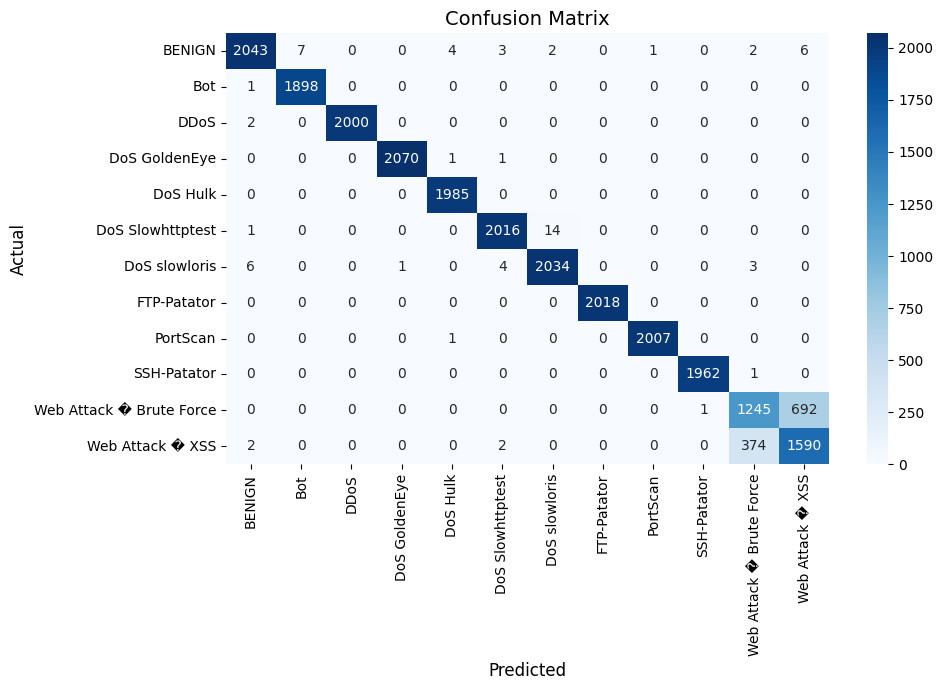

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)

plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()


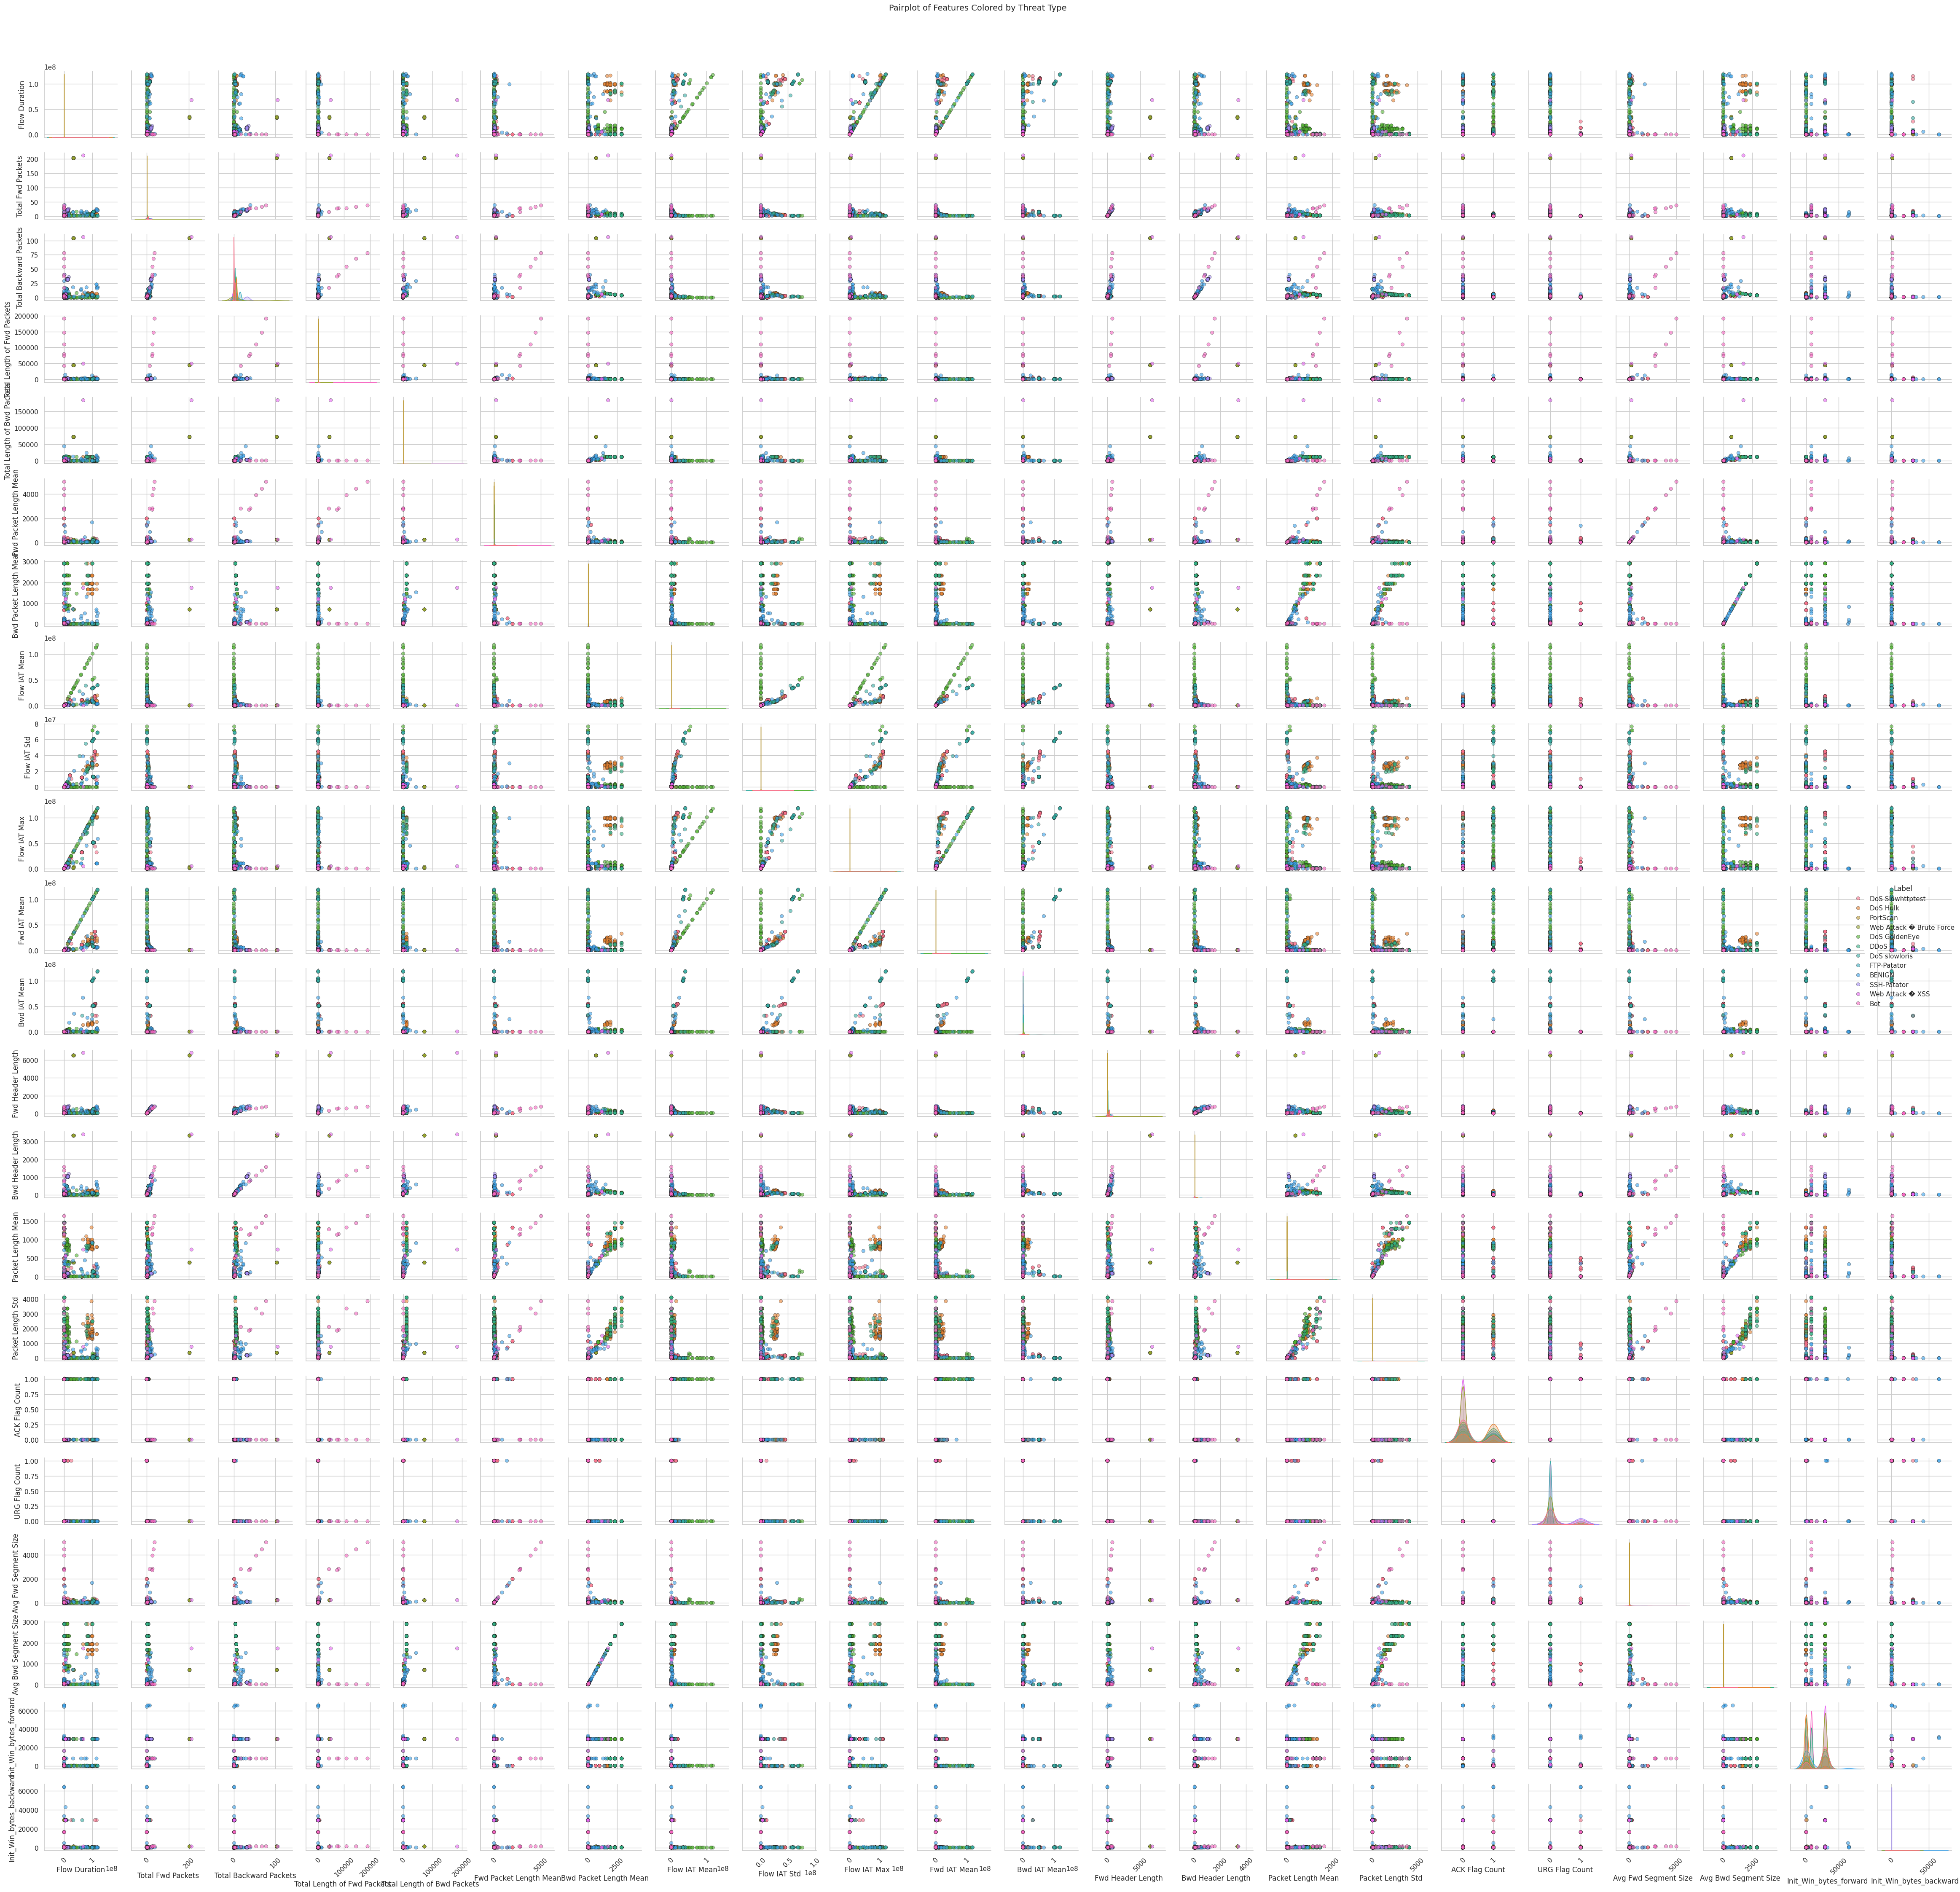

In [ ]:
possible_label_columns = ['label', 'Label', 'class', 'Class', 'target', 'Target']
label_col = None

for col in df.columns:
    if col.lower() in [x.lower() for x in possible_label_columns]:
        label_col = col
        break

if label_col is None:
    raise ValueError("No label column found in dataframe.")

df['Label'] = df[label_col]

features_to_plot = [
    'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
    'Fwd Packet Length Mean', 'Bwd Packet Length Mean',
    'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
    'Fwd IAT Mean', 'Bwd IAT Mean',
    'Fwd Header Length', 'Bwd Header Length',
    'Packet Length Mean', 'Packet Length Std',
    'ACK Flag Count', 'URG Flag Count',
    'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
    'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
    'Label'
]

# Balanced sampling (e.g., 100 per class)
samples_per_class = 100
pair_df_list = []

for label in df['Label'].unique():
    subset = df[df['Label'] == label]
    pair_df_list.append(subset[features_to_plot].sample(
        n=min(samples_per_class, len(subset)),
        random_state=42
    ))

pair_df = pd.concat(pair_df_list)

# Plot pairplot
sns.set(style="whitegrid")
pair_plot = sns.pairplot(
    pair_df,
    hue="Label",
    palette="husl",
    diag_kind="kde",
    plot_kws={'alpha': 0.6, 's': 35, 'edgecolor': 'k'},
    height=2
)

for ax in pair_plot.axes.flatten():
    if ax is not None:
        ax.tick_params(axis='x', labelrotation=45)
        ax.tick_params(axis='y', labelrotation=0)

pair_plot.fig.suptitle("Pairplot of Features Colored by Threat Type", y=1.02, fontsize=14)
plt.tight_layout()
plt.savefig("pairplot_22_classes.png", dpi=300, bbox_inches='tight')
plt.show()


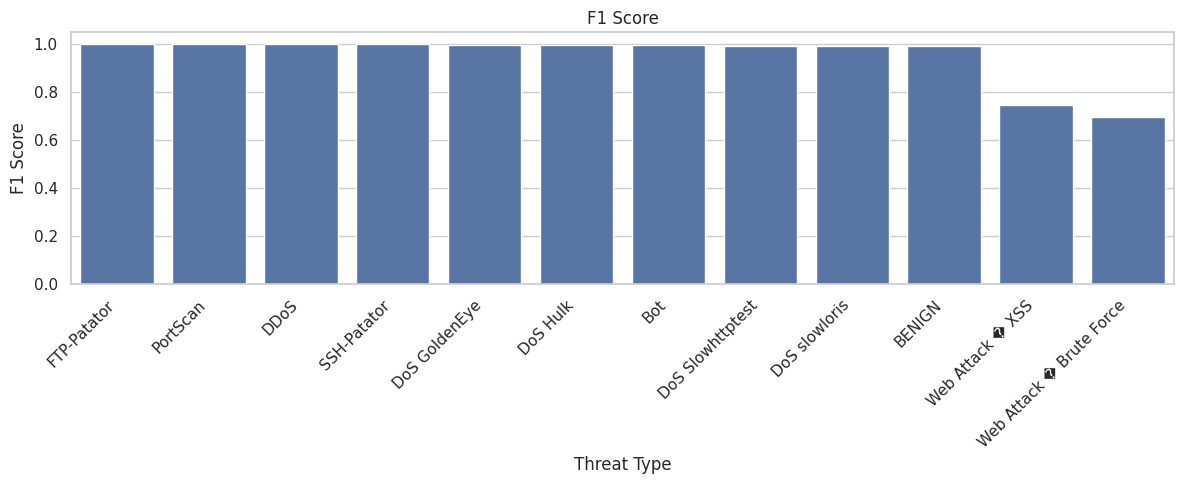

In [ ]:
f1 = f1_score(y_test, y_pred, average=None)

# Get class names from LabelEncoder (assuming 0 to n_classes-1 encoded labels)
class_labels = label_encoder.inverse_transform(np.arange(len(f1)))

# Create DataFrame for plotting
f1_df = pd.DataFrame({'Threat Type': class_labels, 'F1 Score': f1})
f1_df = f1_df.sort_values('F1 Score', ascending=False)


plt.figure(figsize=(12, 5))
sns.barplot(data=f1_df, x='Threat Type', y='F1 Score')
plt.title(f'F1 Score')
plt.ylabel("F1 Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("f1_score.png", dpi=300)
plt.show()


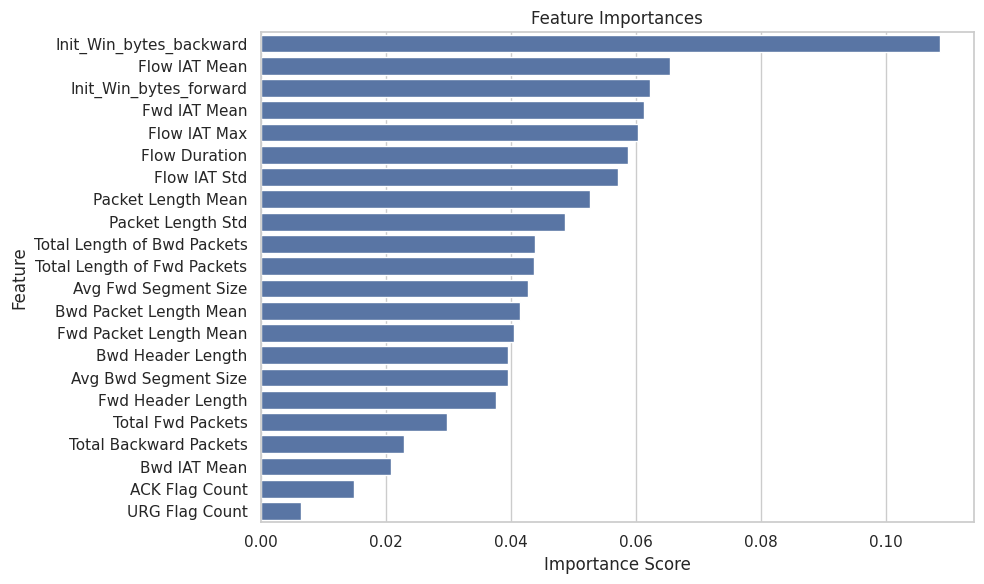

In [ ]:
# Load the trained Random Forest model
model = joblib.load("model/random_forest_model.pkl")

# Load X (make sure it's the same dataset you used during training)
X = joblib.load("model/X_resampled.pkl")

X = joblib.load("model/X_resampled.pkl")

# Manually set the column names
feature_names = [
    'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
    'Fwd Packet Length Mean', 'Bwd Packet Length Mean',
    'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
    'Fwd IAT Mean', 'Bwd IAT Mean',
    'Fwd Header Length', 'Bwd Header Length',
    'Packet Length Mean', 'Packet Length Std',
    'ACK Flag Count', 'URG Flag Count',
    'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
    'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
]

# Assign columns if needed
if not isinstance(X, pd.DataFrame):
    X = pd.DataFrame(X, columns=feature_names)


# Check if the model supports feature importances
if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]  # descending order

    # Feature names
    if hasattr(X, 'columns'):
        feature_names = np.array(X.columns)
    else:
        feature_names = np.array([f'Feature {i}' for i in range(X.shape[1])])

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=feature_names[indices])
    plt.title("Feature Importances")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig("feature_importance.png", dpi=300)
    plt.show()
else:
    print("The Random Forest model does not support feature_importances_.")


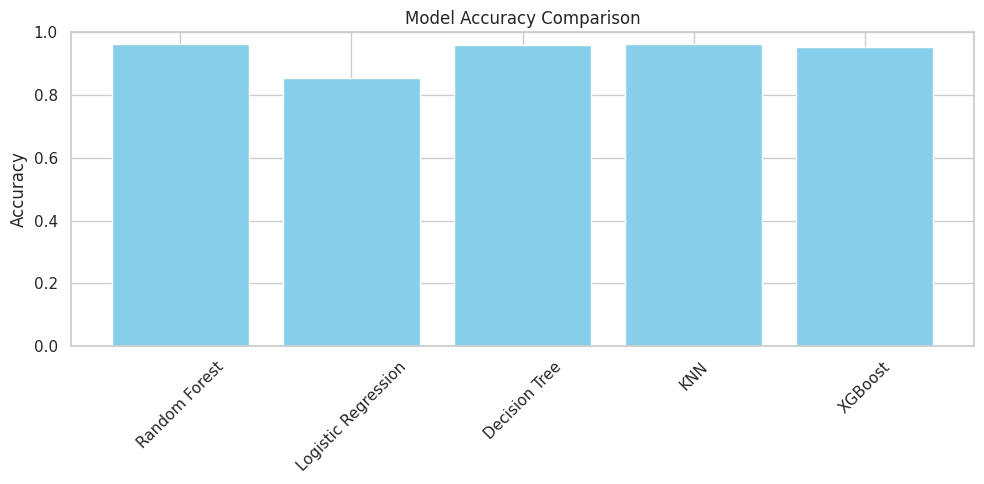

In [ ]:
results_df = pd.DataFrame(results)

model_names = results_df["Model"]
accuracies = results_df["Accuracy"]

plt.figure(figsize=(10, 5))
plt.bar(model_names, accuracies, color='skyblue')
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("model_accuracy_comparison.png", dpi=300)
plt.show()



**Testing the Model**

In [ ]:
import pandas as pd
import joblib

model = joblib.load("/content/model/random_forest_model.pkl")  # Change to your preferred model path
scaler = joblib.load("/content/model/scaler.pkl")
label_encoder = joblib.load("/content/model/label_encoder.pkl")

test_df = pd.read_csv("/content/test123.csv")
print("📄 Loaded test123.csv with shape:", test_df.shape)

test_df.columns = [col.strip() for col in test_df.columns]
X_test = test_df.astype(float)

X_scaled = scaler.transform(X_test)

preds = model.predict(X_scaled)
predicted_labels = label_encoder.inverse_transform(preds)

results_df = pd.DataFrame({
    'Predicted Attack Type': predicted_labels
})
print("Prediction Results:")
print(results_df)

# ✅ Count of each predicted class
print("\n Prediction Count Summary:")
print(results_df['Predicted Attack Type'].value_counts())


📄 Loaded test123.csv with shape: (14, 22)
Prediction Results:
       Predicted Attack Type
0                        Bot
1                       DDoS
2              DoS GoldenEye
3                   DoS Hulk
4           DoS Slowhttptest
5              DoS slowloris
6                FTP-Patator
7                     BENIGN
8                     BENIGN
9                   PortScan
10               SSH-Patator
11  Web Attack � Brute Force
12  Web Attack � Brute Force
13          Web Attack � XSS

 Prediction Count Summary:
Predicted Attack Type
Web Attack � Brute Force    2
BENIGN                      2
Bot                         1
DDoS                        1
DoS Hulk                    1
DoS GoldenEye               1
DoS slowloris               1
DoS Slowhttptest            1
FTP-Patator                 1
PortScan                    1
SSH-Patator                 1
Web Attack � XSS            1
Name: count, dtype: int64


In [ ]:
import pandas as pd
import joblib

model = joblib.load("/content/model/random_forest_model.pkl")  # Change to your preferred model path
scaler = joblib.load("/content/model/scaler.pkl")
label_encoder = joblib.load("/content/model/label_encoder.pkl")

test_df = pd.read_csv("/content/data_to_test.csv")
print("📄 Loaded test123.csv with shape:", test_df.shape)

test_df.columns = [col.strip() for col in test_df.columns]
X_test = test_df.astype(float)

X_scaled = scaler.transform(X_test)

preds = model.predict(X_scaled)
predicted_labels = label_encoder.inverse_transform(preds)

results_df = pd.DataFrame({
    'Predicted Attack Type': predicted_labels
})
print("Prediction Results:")
print(results_df)

# ✅ Count of each predicted class
print("\n Prediction Count Summary:")
print(results_df['Predicted Attack Type'].value_counts())


📄 Loaded test123.csv with shape: (20, 22)
Prediction Results:
   Predicted Attack Type
0                    Bot
1                   DDoS
2          DoS GoldenEye
3               DoS Hulk
4          DoS slowloris
5                 BENIGN
6                 BENIGN
7                 BENIGN
8                 BENIGN
9                 BENIGN
10                BENIGN
11                BENIGN
12                BENIGN
13                BENIGN
14                BENIGN
15                BENIGN
16                BENIGN
17                BENIGN
18                BENIGN
19                BENIGN

 Prediction Count Summary:
Predicted Attack Type
BENIGN           15
Bot               1
DDoS              1
DoS GoldenEye     1
DoS Hulk          1
DoS slowloris     1
Name: count, dtype: int64
